## KDS75

In [1]:
# Load modules
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import seaborn as sns

from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import xarray as xr


netcdf_index loaded.


In [10]:
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage


In [11]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [12]:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 35014:127.0.0.1:35014 vdi-n6.nci.org.au -l pas561


Client Scheduler: tcp://127.0.0.1:43122 Dashboard: http://127.0.0.1:35014,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [13]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)
#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.0


In [6]:
cc.build_index()


Found 48708 new variables
Saving results in database...
Indexing complete.


True

In [7]:
configuration = 'mom01v5'
expts = cc.get_experiments(configuration)
display(expts)


['GFDL50',
 'KDS75',
 'KDS75_PI',
 'KDS75_UP',
 'KDS75_WOA13',
 'KDS75_newbathy_CORE',
 'KDS75_newbathy_JRA',
 'KDS75_newbathy_JRA_runoff',
 'KDS75_salt10days',
 'KDS75_saltfluxes',
 'KDS75_wind',
 'kds75_cp',
 'kds75_wp2']

In [8]:
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp/'
NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/'


In [16]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/kds75.uvwt.230-257.ncra.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print(geolon_t.shape)

fh=fcor/ht
print(fh.shape)

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the file
print(st_ocean.shape)
#print potrho.shape
print(yt_ocean.shape)

#fix this to a 12 month average
nc = Dataset('/g/data3/hh5/tmp/pas561/kds75_cp/dzt.9month.nc', mode='r') # file handle, open in read only mode
dzt = nc.variables['dzt'][:]
nc.close() # close the file
print(dzt.shape)

#fix this to a 12 month average
nc = Dataset('/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/output443/ocean.nc', mode='r') # file handle, open in read only mode
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print(potrho.shape)


dzt=np.squeeze(dzt)
print(dzt.shape)

(2700, 3600)
(2700, 3600)
(75,)
(2700,)
(1, 75, 2700, 3600)
(80,)
(75, 2700, 3600)


In [20]:
expt='kds75_cp'
cntrl_tx= cc.get_nc_variable(expt,
                    'ocean.nc',
                    'tau_x',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
print(cntrl_tx.shape)
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
cntrl_tx_1974 = cntrl_tx.sel(yu_ocean=slice(-80,-30)).sel(time='1974').mean('time')
#cntrl_tx_1974.plot.pcolormesh()

expt='kds75_wp2'
pert_tx= cc.get_nc_variable(expt,
                    'ocean.nc',
                    'tau_x',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
print(pert_tx.shape)
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
pert_tx_1974 = pert_tx.sel(yu_ocean=slice(-80,-30)).sel(time='1974').mean('time')
#pert_tx_1974.plot.pcolormesh()


plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Wind Stress')

clev = np.arange(-.2,.2,.01)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.tau_x[t1:t2,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Control Zonal Wind Stress')

#clev = np.arange(-.1,.1,.01)

plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.tau_x[t1:t2,:,:].mean('time').load()-cntrl.tau_x[t1:t2,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Anomaly')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m2')

#of = os.path.join(NYFPertDir,'tau_x.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'tau_x.png')
plt.savefig(of,dpi=220)


(67, 2700, 3600)


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=45), HTML(value='')))

KeyError: 'geolon_c'

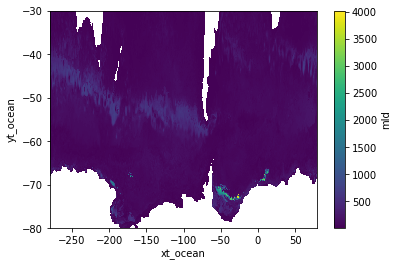

In [31]:
expt='kds75_cp'
mld= cc.get_nc_variable(expt,
                    'ocean_month.nc',
                    'mld',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
mean_mld = mld.sel(yt_ocean=slice(-80,-30)).sel(time='1975-09').mean('time')
#mean_mld = mld.mean('time')
mean_mld.plot.pcolormesh()

In [25]:
expt='kds75_wp2'
mld= cc.get_nc_variable(expt,
                    'ocean.nc',
                    'tau_x',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
print(mld.shape)
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
#mean_mld = mld.sel(yt_ocean=slice(-80,-30)).sel(time='1975-09').mean('time')
#mean_mld = mld.mean('time')
#mean_mld.plot.pcolormesh()

KeyError: 'geolat_c'

In [ ]:
pert_i=cc.get_nc_variable('kds75_wp2',
                    'ice_month.nc',
                    'CN',
                    time_units='days since 1973-04-01',
                    use_bag=True,
                    chunks={'time': 1}
                    )
septice = pert_i.sel(yt_ocean=slice(-80,-55)).sum('ct')

In [ ]:
septice.isel(time=18).plot.pcolormesh()

In [11]:
#if i fist ncrcat the CN data into an netcdf file, it works and is very fast
Ocean_File = os.path.join(NYFPertDir,'CN.cat.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN.shape
print pert_i.CN[:,:,:,:].sum('ct').shape

(87, 5, 2700, 3600)
(87, 2700, 3600)


In [ ]:
#instead I can opt for the slow, but successful version below:
print pert.ty_trans_rho.shape[0]

pert_gmoc=np.zeros((pert.ty_trans_rho.shape[0],pert.ty_trans_rho.shape[1],pert.ty_trans_rho.shape[2]))
print pert_gmoc.shape

for t in range(pert.ty_trans.shape[0]):
    print t
    pert_gmoc[t,:,:]=pert.ty_trans_rho[t,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
a=np.save(of,pert_gmoc)


In [ ]:
expt='kds75_cp'
psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=5,
                          time_units = 'days since 1700-01-01')
psi = psi.sum('grid_xt_ocean')
psi_avg = psi.cumsum('potrho').mean('time') -  psi.sum('potrho').mean('time')
psi_avg.load()

Text(0.5,1,'Overturning in kds75_cp')

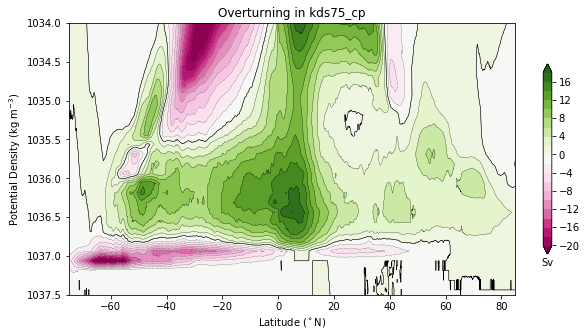

In [33]:
plt.figure(figsize=(10, 5)) 
clev=np.arange(-20,20,2)
plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()
    
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning in %s' % expt)

In [ ]:
expts = ['kds75_cp','kds75_wp2']

for e in expts:
    psi = cc.get_nc_variable(e, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},
                          time_units = 'days since 1860-01-01')
    psi = psi.sum('grid_xt_ocean')
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    psi_aabw = psi_sum.sel(method='Nearest',grid_yu_ocean=-40).sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean()
    psi_aabw = psi_aabw.compute()
    psi_aabw.plot(label=e)
    
    if e == 'kds75_cp':
        cntrl_gmoc = psi_sum
        of=os.path.join(NYFCntrlDir,'gmoc_adv_rho.npy')
        a=np.save(of,cntrl_gmoc)
    if e == 'kds75_wp2':
        pert_gmoc = psi_sum
        of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
        a=np.save(of,pert_gmoc)
    

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=67), HTML(value='')))

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7fcb551130d0>, {'op': 'update-graph', 'tasks': {"('stack-7dc687597b77c9c4a472af74594b89b2', 15)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 15)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 2)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 2)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 12)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 12)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 3)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 3)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 13)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 13)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 0)": <Serialize: ('mean_agg-aggregate-stack-7dc687597b77c9c4a472af74594b89b2', 0)>, "('stack-7dc687597b77c9c4a472af74594b89b2', 10)": <Serialize: ('me